# Самые крупные и частые траты за последние три месяца

In [3]:
!pip install pandas openpyxl
!pip install xlrd

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
import os

Откроем отчет из файла:

In [2]:
file_name = "operations Wed Jun 01 10_16_57 MSK 2022-Mon Aug 15 10_27_19 MSK 2022.xls"
file_dir = "/Users/dopetukhov/Downloads/"
file_path = os.path.join(file_dir, file_name)

def read_report(file_name: str) -> pd.DataFrame:
    return pd.ExcelFile(file_path).parse(0)
df = read_report(file_path)

Возьмем только нужные нам столбцы и запретим мусорные категории в виде переводов с карты на карту, а также установим порог, по которому будем определять, крупная ли операция и введем некоторые константы:

In [3]:
columns_to_fetch = ["Дата операции", "Сумма операции", "Категория", "Описание", "Бонусы (включая кэшбэк)"]
banned_categories = ["Переводы/иб", "Переводы", "Наличные", np.nan]
price_threshold = -4000
sort_by_col = "Дата операции"
category = "Категория"
exp_total = "Сумма операции"
df = df[columns_to_fetch][~df[category].isin(banned_categories)]
df.head()

,Дата операции,Сумма операции,Категория,Описание,Бонусы (включая кэшбэк)
0,15.08.2022 10:27:19,-814.00,Супермаркеты,ВкусВилл,4.0
1,15.08.2022 10:24:53,200.00,Другое,Перевод между счетами,0.0
3,12.08.2022 23:31:19,-459.97,Фастфуд,Burger King,4.0
4,12.08.2022 23:28:48,1000.00,Другое,Перевод между счетами,0.0
6,12.08.2022 17:34:53,-905.00,Разные товары,Deerkalyan,9.0


Отфильтруем и отсортируем крупные траты:

In [5]:
from typing import List

def filter_columns(
                   df: pd.DataFrame,
                   columns_fetch: List[str],
                   by_field: str,
                   threshold: int,
                   ban_from_column: str,
                   banned_names: List[str],
                  ) -> pd.DataFrame:
    return df[columns_fetch][(df[by_field] <= threshold) &
                             (~df[ban_from_column].isin(banned_names))]


df_processed = filter_columns(df, columns_to_fetch, exp_total, price_threshold, category, banned_categories)

In [8]:
def column_to_datetime(df: pd.DataFrame,
                       column_name: str,
                       format: str = "%d.%m.%Y %H:%M:%S") -> pd.DataFrame:
    df[column_name] = pd.to_datetime(df[column_name], format=format)
    return df


df_processed = column_to_datetime(df_processed, sort_by_col)

In [9]:
df_processed.sort_values(by=[sort_by_col])

,Дата операции,Сумма операции,Категория,Описание,Бонусы (включая кэшбэк)
356,2022-06-15 19:48:57,-4096.79,Супермаркеты,Ашан,20.0
347,2022-06-17 18:42:53,-12500.00,Авто услуги,Avtochipservis,625.0
343,2022-06-18 10:47:34,-21600.00,Мед. услуги,OOO Kids Smaile,108.0
319,2022-06-22 20:40:02,-7905.00,Разные товары,HookahMarket,79.0
300,2022-06-23 20:05:44,-107306.25,Турагентства,Servis Turizm,0.0
272,2022-06-28 19:07:11,-5299.00,"Одежда, обувь",Intimissimi,529.9
241,2022-07-02 14:43:16,-5446.00,"Одежда, обувь",Crocs,27.0
150,2022-07-18 00:25:00,-19990.00,"Одежда, обувь",Lamoda,99.0


Посчитаем кэшбэк за крупные траты:

In [11]:
def count_cashbask(df: pd.DataFrame) -> float:
    return df["Бонусы (включая кэшбэк)"].sum()


cashback_total = count_cashbask(df_processed)

In [12]:
f"Получено кэшбэка: {cashback_total}"

'Получено кэшбэка: 1487.9'

Разделим траты на категории:

In [13]:
from typing import Dict


def categorize_purchases(df: pd.DataFrame) -> Dict[str, float]:
    categories = set(df[category])
    return {cat : df_processed[exp_total][df_processed[category] == cat].sum() 
                         for cat in categories}

In [14]:
categorized_purchases = categorize_purchases(df_processed)

In [16]:
categorized_purchases

{'Разные товары': -7905.0,
 'Авто услуги': -12500.0,
 'Супермаркеты': -4096.79,
 'Мед. услуги': -21600.0,
 'Турагентства': -107306.25,
 'Одежда, обувь': -30735.0}

Найдем самую дорогую категорию:

In [17]:
def find_most_expensive_category(categorized_purchases: Dict[str, float]) -> Dict[str, float]:
    most_exp_cat = min(categorized_purchases, key=categorized_purchases.get)
    return {most_exp_cat: abs(categorized_purchases[most_exp_cat])}

In [18]:
find_most_expensive_category(categorized_purchases)

{'Турагентства': 107306.25}

Разделим траты на мелкие, небольшие, средние, крупные и очень крупные:

In [29]:
from typing import Tuple

def split_expenses_to_groups(df: pd.DataFrame) -> Tuple:
    groups = {}
    expenses_categories = {
                            "very small": [0, -499],
                            "small": [-500, -1000],
                            "medium": [-1000, -3999],
                            "big": [-4000, -9999],
                            "very big": [-10000, -150000]
                          }
    very_small_exp = df[(df[exp_total] < expenses_categories["very small"][0])
       & (df[exp_total] > expenses_categories["very small"][1])]
    groups["very small"] = (very_small_exp, very_small_exp[exp_total].sum())
    
    small_exp = df[(df[exp_total] < expenses_categories["small"][0])
   & (df[exp_total] > expenses_categories["small"][1])]
        
    medium_exp = df[(df[exp_total] < expenses_categories["medium"][0])
   & (df[exp_total] > expenses_categories["medium"][1])]
    
    big_exp = df[(df[exp_total] < expenses_categories["big"][0])
   & (df[exp_total] > expenses_categories["big"][1])]
    
    very_big_exp = df[(df[exp_total] < expenses_categories["very big"][0])
   & (df[exp_total] > expenses_categories["very big"][1])]
    
    return (very_small_exp, very_small_exp[exp_total].sum()), (small_exp, small_exp[exp_total].sum()), (medium_exp, medium_exp[exp_total].sum()), (big_exp, big_exp[exp_total].sum()), (very_big_exp, very_big_exp[exp_total].sum())

In [32]:
(very_small, very_small_sum), (small, small_sum), (medium, medium_sum), (big, big_sum), (very_big, very_big_sum) = split_expenses_to_groups(df)

In [34]:
very_small

,Дата операции,Сумма операции,Категория,Описание,Бонусы (включая кэшбэк)
3,2022-08-12 23:31:19,-459.97,Фастфуд,Burger King,4.0
7,2022-08-12 10:37:12,-403.00,Супермаркеты,Яндекс.Лавка,2.0
9,2022-08-12 09:23:49,-269.59,Супермаркеты,Ашан,1.0
12,2022-08-11 23:32:05,-59.00,Другое,Плата за оповещения об операциях,0.0
17,2022-08-11 21:46:44,-300.00,Супермаркеты,Самокат,1.0
...,...,...,...,...,...
388,2022-06-05 12:06:08,-425.00,Супермаркеты,ВкусВилл,2.0
389,2022-06-04 23:20:37,-1.00,Транспорт,Московский транспорт,0.0
391,2022-06-04 22:01:16,-279.54,Аренда авто,Яндекс.Драйв,2.0
394,2022-06-03 23:40:34,-11.00,Аренда авто,Яндекс.Драйв,0.0


In [53]:
def get_expenses_within_interval(df: pd.DataFrame, lower: int, upper: int, columns_to_fetch: List[str]=exp_total, remove_sign=True) -> pd.DataFrame:
    hist_data = df[columns_to_fetch][(df[exp_total] < lower) & (df[exp_total] > -upper)]
    if remove_sign:
        hist_data = hist_data.apply(np.abs)
    return hist_data
hist_data = get_expenses_within_interval(df, 0, 20000)

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


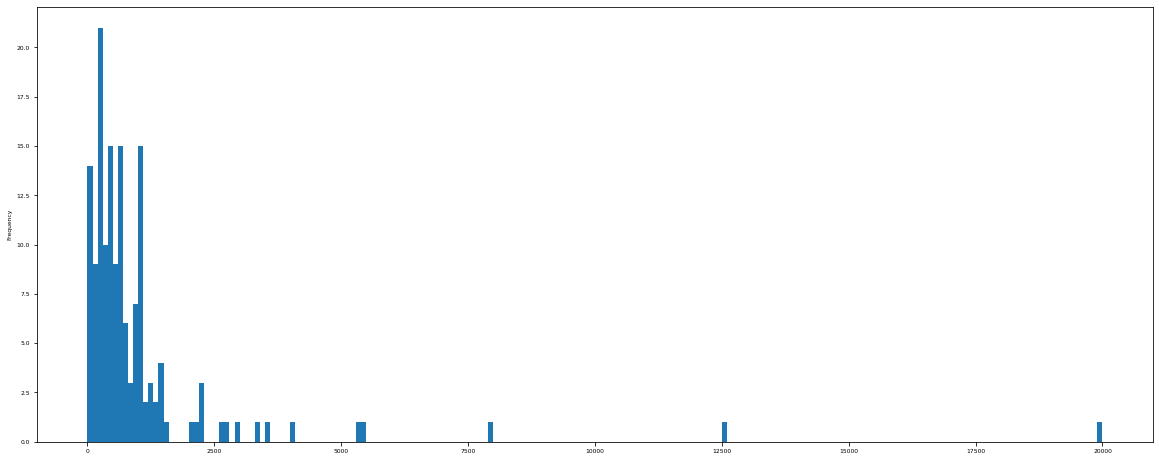

In [54]:
!pip install matplotlib
ax = hist_data.plot.hist(bins=200, figsize=(20, 8))

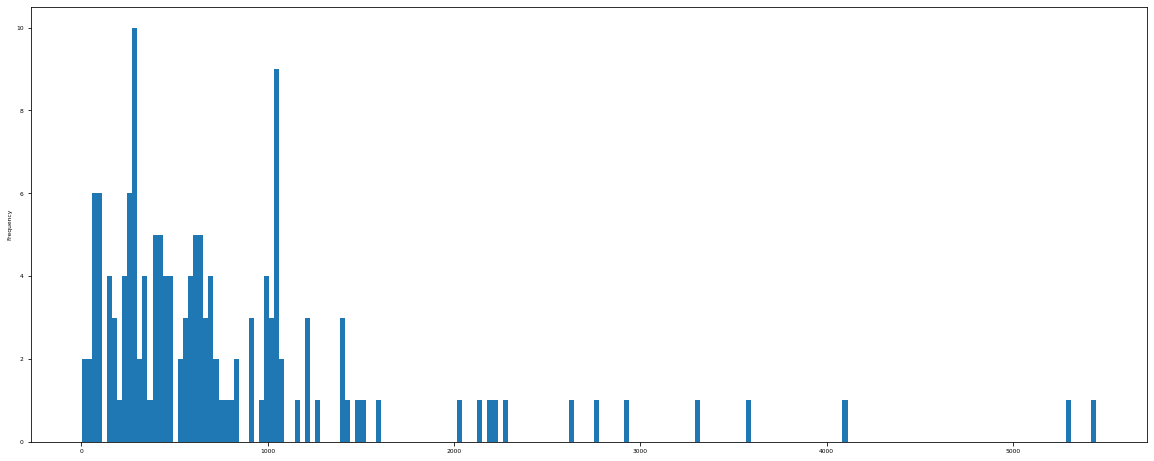

In [55]:
hist_data = get_expenses_within_interval(df, 0, 6000)
ax = hist_data.plot.hist(bins=200, figsize=(20, 8))

In [56]:
pie_data_raw = get_expenses_within_interval(df, 0, 6000, [exp_total, category], False)

def create_pie_data(df: pd.DataFrame) -> pd.DataFrame:
    categories = set(df[category])
    categorized_purchases = {cat : df[exp_total][df[category] == cat].sum() 
                         for cat in categories}
    categorized_purchases = {k: v for k, v in sorted(categorized_purchases.items(), key=lambda item: item[1])}

    for k,v in categorized_purchases.items():
        categorized_purchases[k] = [v]
    return pd.DataFrame.from_dict(categorized_purchases, orient="index", columns=[exp_total]).apply(np.abs)

pie_data = create_pie_data(pie_data_raw)
pie_data.head()

,Сумма операции
Супермаркеты,55503.75
Топливо,16483.83
"Одежда, обувь",12441.00
Разные товары,11226.00
Фастфуд,8144.32


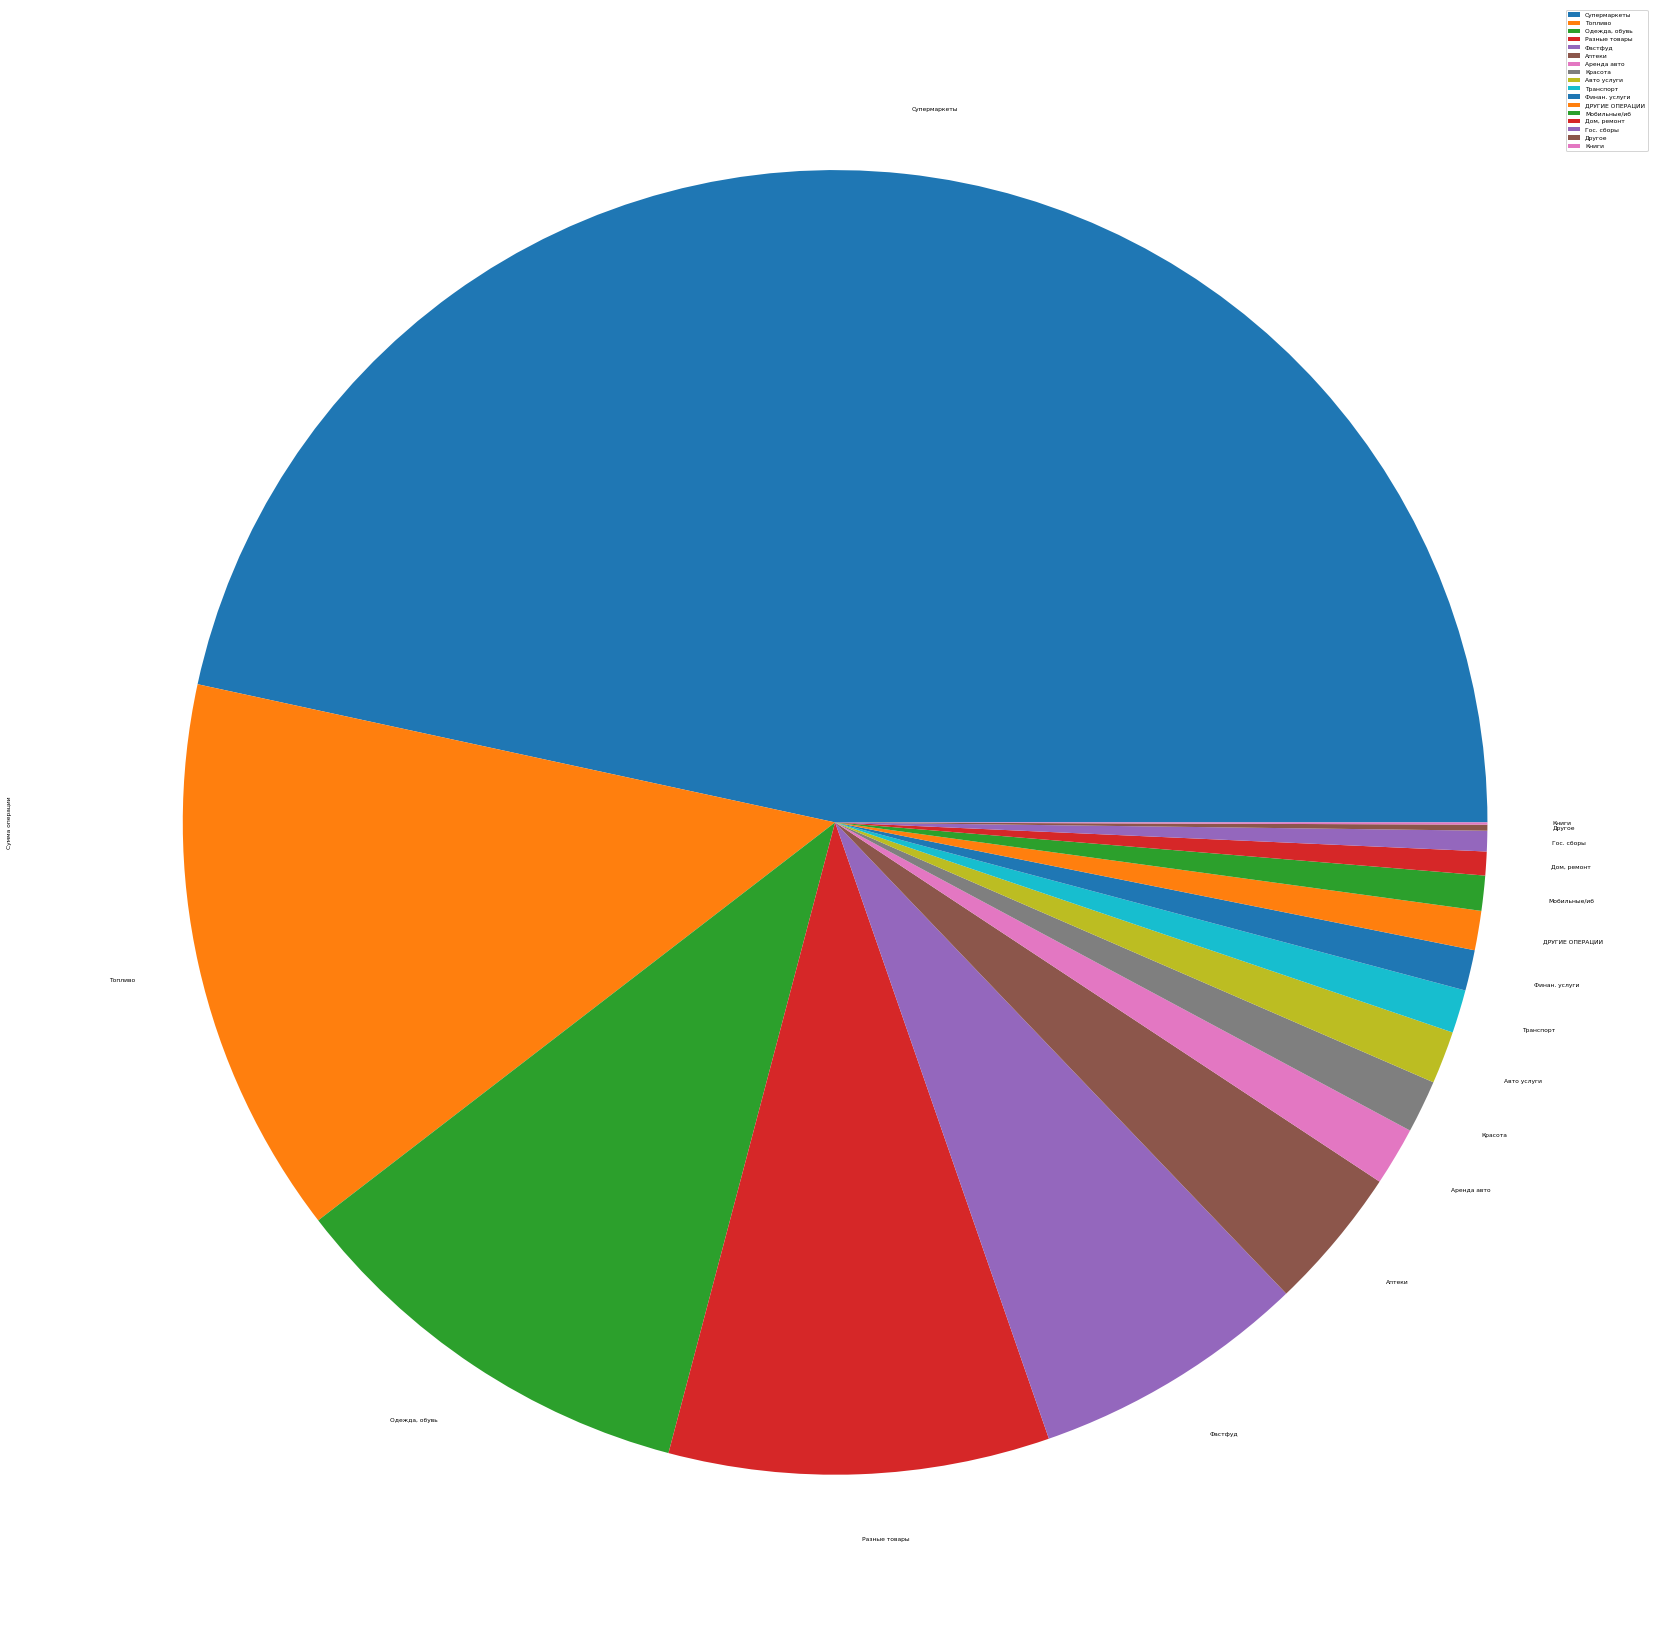

In [57]:
def plot_expenses_pie(pie_data: pd.DataFrame) -> None:
    plot = pie_data.plot.pie(y=exp_total, figsize=(30, 30))
    import matplotlib as mpl
    mpl.rcParams['font.size'] = 6

plot_expenses_pie(pie_data)

In [75]:
def create_heatmap_data(df: pd.DataFrame) -> pd.DataFrame:
    heat_data = df["Дата операции"][(df[exp_total] < 0) & (df[exp_total] > -6000)]
    datetime_format = "%d.%m.%Y %H:%M:%S"
    return pd.to_datetime(heat_data, format=datetime_format)


heatmap_data = create_heatmap_data(df)

In [76]:
!pip install seaborn

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [77]:
hours = heatmap_data.apply(lambda x: x.time().hour)

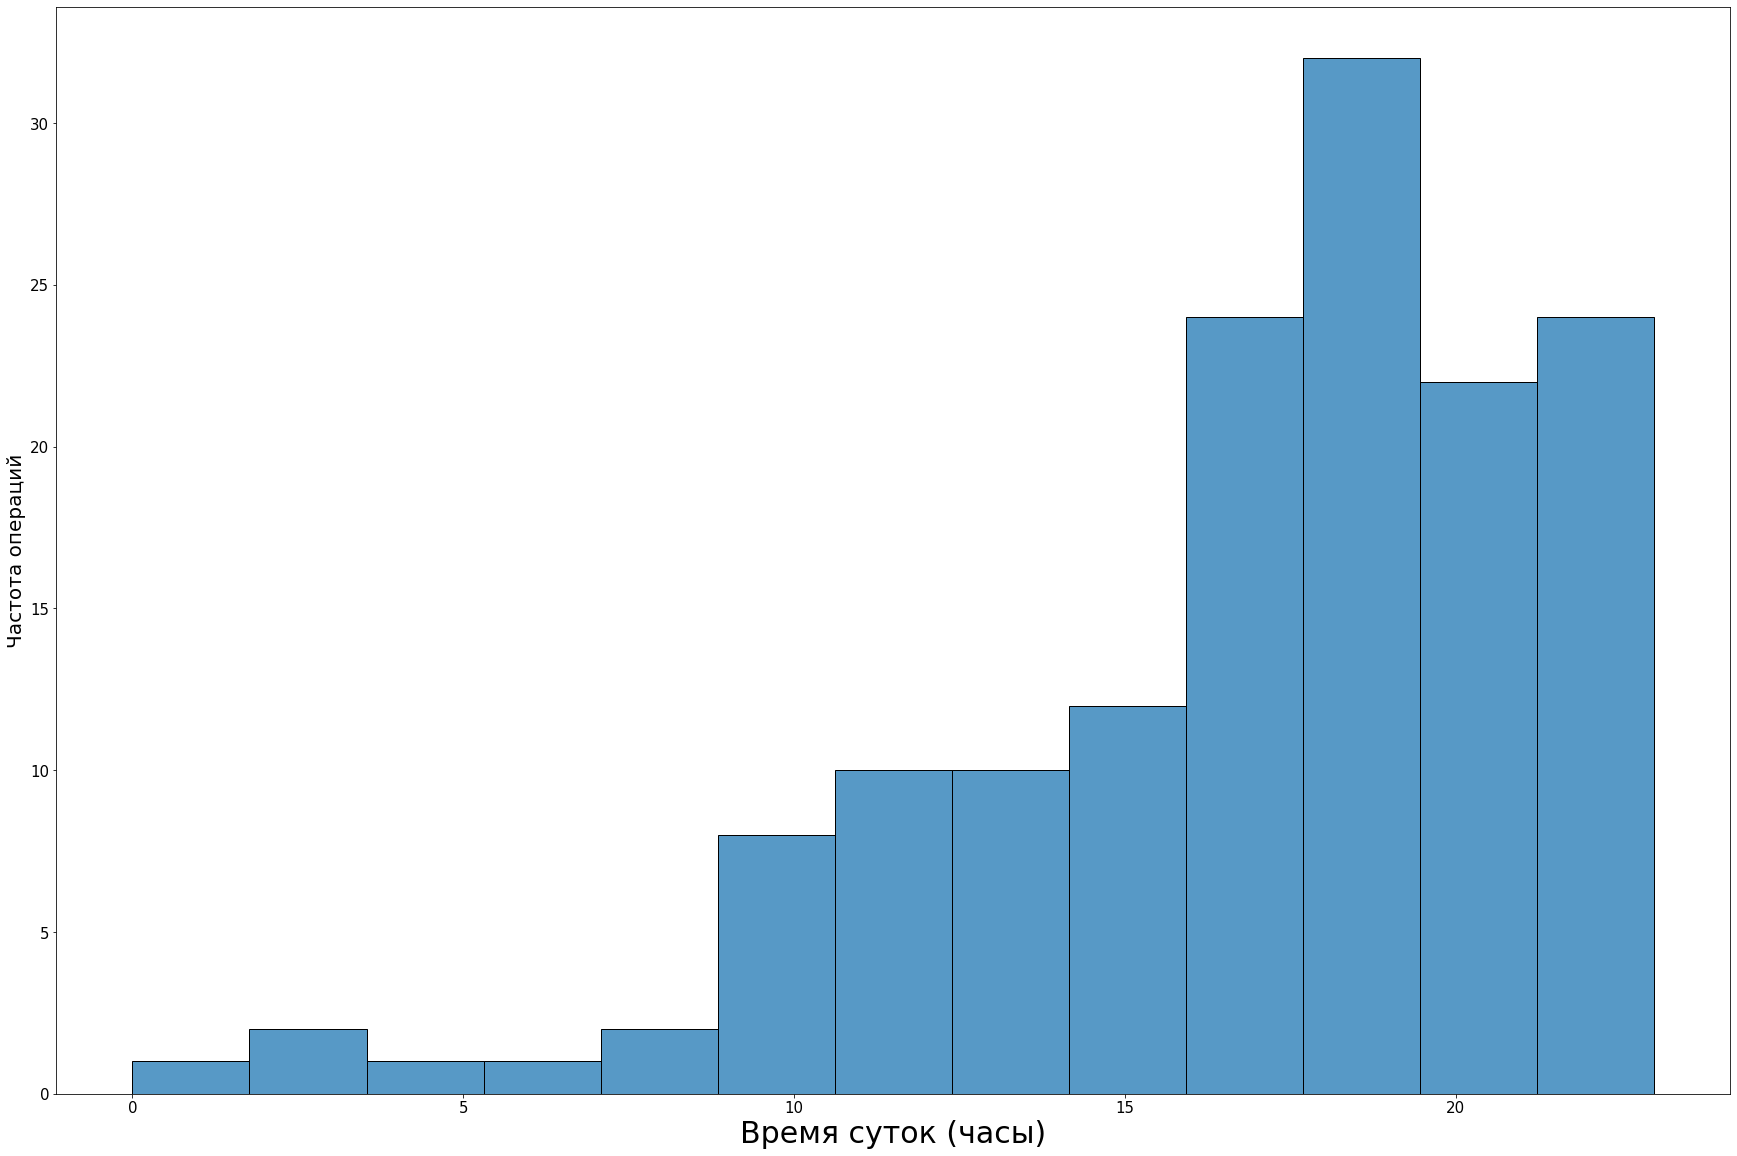

In [78]:
import seaborn as sns
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(30, 20))
h = sns.histplot(ax=ax, data=hours)
h.set_xlabel("Время суток (часы)",fontsize=30)
h.set_ylabel("Частота операций",fontsize=20)
h.tick_params(labelsize=15)
pyplot.show()